<a href="https://colab.research.google.com/github/fmoreira1/CBLPromoter/blob/main/CBLPromoter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CBLPromoter
### by Fernando Moreira Ruiz

# Import Libraries

In [ ]:
!pip install Bio
!pip install gdown

     |████████████████████████████████| 94 kB 2.0 MB/s 
     |████████████████████████████████| 2.3 MB 9.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import re
import random

import textwrap
from Bio import SeqIO
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

# necessary to use colab TPUs
import os
from google.colab import auth
auth.authenticate_user()

# Load Data

In [ ]:
!gdown --id 199We0DbFLfSthZty69VvUt7nGxP6w5Ft
!gdown --id 1Mkbq-4WrWVi5dvIchCzHjOvb_mtyrahw
!gdown --id 1FPasW-WX5r-IwulnAEbm1e_ZiLcq17vQ
!gdown --id 1aAoUA7omGZDJqIr3KkPL93X6v2I2s_TA

Downloading...
From: https://drive.google.com/uc?id=199We0DbFLfSthZty69VvUt7nGxP6w5Ft
To: /content/dp_human_non_tata
9.79MB [00:00, 154MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Mkbq-4WrWVi5dvIchCzHjOvb_mtyrahw
To: /content/dp_human_tata
100% 1.13M/1.13M [00:00<00:00, 71.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FPasW-WX5r-IwulnAEbm1e_ZiLcq17vQ
To: /content/dp_mouse_non_tata
9.79MB [00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aAoUA7omGZDJqIr3KkPL93X6v2I2s_TA
To: /content/dp_mouse_tata
100% 1.13M/1.13M [00:00<00:00, 74.6MB/s]


In [ ]:
!cp 'dp_human_non_tata' human_non_tata.fasta
!cp 'dp_human_tata' human_tata.fasta
!cp 'dp_mouse_non_tata' mouse_non_tata.fasta
!cp 'dp_mouse_tata' mouse_tata.fasta
!ls

adc.json	   dp_mouse_non_tata	 human_tata.fasta      sample_data
dp_human_non_tata  dp_mouse_tata	 mouse_non_tata.fasta
dp_human_tata	   human_non_tata.fasta  mouse_tata.fasta


# Convert Data to Pandas DF

## Human

In [ ]:
records = SeqIO.parse("human_non_tata.fasta", "fasta")
SeqIO.write(records, "human_non_tata.tab", "tab")
human_df = pd.read_csv('human_non_tata.tab', sep='\t', header=None)
header = ['Name', 'Sequence']
human_df.columns = header[:len(human_df.columns)]
human_df

,Name,Sequence
0,FP020532,AGCCACGTGAGTCGCTGGGCTATGGGTGGTGGTGGGGGTGAGGGAG...
1,FP020301,TACTTCCGGTTTCCACGGAGCTCCGCCCCTTAGGGGGGTTCTCGCT...
2,FP008839,GGAGCCTGGTAGGGAGGACAAATCTCTCGAAATCTCAGTTGGCGCT...
3,FP002661,GACCTCCTGTGGTGCTTTCAGTTAGAGCCACTCCCTTTACAAACAA...
4,FP004964,AATATCTAGGCTTTTAAAATAAGGTGAAAATAAAAGGCAAATTGTC...
...,...,...
26528,FP020671,TTAGCCTCTAGGCCTCAGTAGTCCCAGGGAAGTAATAATCGCTATT...
26529,FP017673,AATTAAACGGTAGTTAAGAGCAAAGGTGAAAATGAGAAAAAAAAGG...
26530,FP004916,GGAGAGGCTCCCCAAGTTGGCCGGGTGTGGGGAGAGGGGACATAGC...
26531,FP009666,CGCACAGAGCATTCCGTCACCCCAGGCCCACGCTCTCCAGCCCACC...


## Mouse

In [ ]:
records = SeqIO.parse("mouse_non_tata.fasta", "fasta")
SeqIO.write(records, "mouse_non_tata.tab", "tab")
mouse_df = pd.read_csv('mouse_non_tata.tab', sep='\t', header=None)
header = ['Name', 'Sequence']
mouse_df.columns = header[:len(mouse_df.columns)]
mouse_df

,Name,Sequence
0,FP020532,AGCCACGTGAGTCGCTGGGCTATGGGTGGTGGTGGGGGTGAGGGAG...
1,FP020301,TACTTCCGGTTTCCACGGAGCTCCGCCCCTTAGGGGGGTTCTCGCT...
2,FP008839,GGAGCCTGGTAGGGAGGACAAATCTCTCGAAATCTCAGTTGGCGCT...
3,FP002661,GACCTCCTGTGGTGCTTTCAGTTAGAGCCACTCCCTTTACAAACAA...
4,FP004964,AATATCTAGGCTTTTAAAATAAGGTGAAAATAAAAGGCAAATTGTC...
...,...,...
26528,FP020671,TTAGCCTCTAGGCCTCAGTAGTCCCAGGGAAGTAATAATCGCTATT...
26529,FP017673,AATTAAACGGTAGTTAAGAGCAAAGGTGAAAATGAGAAAAAAAAGG...
26530,FP004916,GGAGAGGCTCCCCAAGTTGGCCGGGTGTGGGGAGAGGGGACATAGC...
26531,FP009666,CGCACAGAGCATTCCGTCACCCCAGGCCCACGCTCTCCAGCCCACC...


# Create Negative Datasets

In [ ]:
def CreateNegativeDataSet(df):
  negative_sequences = [] #init return variable
  sequence = df['Sequence'].tolist() #get sequences

  for current_sequence in sequence: #iterate through rows
    split = textwrap.wrap(current_sequence, 15) # split into 20 subsequences of length 15
    split_dict = {}
    
    for x,y in enumerate(split): # turn to dict
      split_dict[x] = y

    # get 12 random sequences
    ran_keys = []
    split_keys = list(split_dict.keys())
    for x in range(0,12):
      ran_keys.append(random.choice(split_keys))

    # substitute the random 12 sequences
    sub_ran_keys = []
    for x in ran_keys:
      sub_ran_keys.append(split[x])
    random.shuffle(sub_ran_keys)

    # combine the substituted and combined sequences
    i = 0
    for x in ran_keys:
      split_dict[x] = sub_ran_keys[i]
      i = i + 1
      
    neg_seq = ''.join(list(split_dict.values())) # convert back to a single string 
    negative_sequences.append(neg_seq) #append to return list

  return negative_sequences

## Negative Dataset for Human

In [ ]:
neg_sequences = CreateNegativeDataSet(human_df)
negative_human_df = pd.DataFrame(neg_sequences)
header = ['Sequence']
negative_human_df.columns = header[:len(negative_human_df.columns)]
negative_human_df

,Sequence
0,GGACAGACTTAGCCCTGGGCTATGGGTGGTGGTGGGGGTGAGGGAG...
1,ATCGAGGCGAGAGAGCGGAGCTCCGCCCCTTAGGGGGGTTCTCGCT...
2,CGCGCTGGGCCAGTAGGACAAATCTCTCGAAATCTCAGTTGGCGCT...
3,GACCTCCTGTGGTGCTTTCAGTTAGAGCCACTCCCTTTACAAACAA...
4,AATATCTAGGCTTTTGTAATGTTATCATCTTAAAAGGCAAATTGTC...
...,...
26528,AGTAATAATCGCTATTTATATAAGATAGGGCTACCGGCTCTGATGC...
26529,AATTAAACGGTAGTTTTCACTGAACCCTGGAATGAGAAAAAAAAGG...
26530,GGAGAGGCTCCCCAACTTACCACCCCTTCCGGAGAGGGGACATAGC...
26531,CGCACAGAGCATTCCGTCACCCCAGGCCCAAAGGTCCCCACTTGAA...


## Negative Dataset for Mouse

In [ ]:
neg_sequences = CreateNegativeDataSet(mouse_df)
negative_mouse_df = pd.DataFrame(neg_sequences)
header = ['Sequence']
negative_mouse_df.columns = header[:len(negative_mouse_df.columns)]
negative_mouse_df

,Sequence
0,AGCCACGTGAGTCGCTGGGCTATGGGTGGTGGTGGGGGTGAGGGAG...
1,CGGAGCTCCGCCCCTGCCACCGGAGCCGCGTAGGGGGGTTCTCGCT...
2,GGAGCCTGGTAGGGAGGACAAATCTCTCGAAATCTCAGTTGGCGCT...
3,GACCTCCTGTGGTGCGAGAACCCTGAGGTGCTCCCTTTACAAACAG...
4,AATATCTAGGCTTTTAAAATAAGGTGAAAATAAAAGGCAAATTGTC...
...,...
26528,TTAGCCTCTAGGCCTCAGTAGTCCCAGGGAAGTAATAATCGCTATT...
26529,GCGCCCCCTCCGAAGGGAAAAAAAAATAAAAATGAGAAAAAAAAGG...
26530,GCCCTGCGAGGGCCTGTTGGCCGGGTGTGGGGAGAGGGGACATAGC...
26531,CGCTCTCCAGCCCACCAGCTCTGGGCGACCGAGCTGCGAACTGAGC...


# Encode Datasets (One Hot)
from https://www.kaggle.com/thomasnelson/working-with-dna-sequence-data-for-mlb

In [ ]:
def string_to_array(my_string):
  ''' Function to convert a DNA sequence string to a numpy array converts to 
  lower case, changes any non 'acgt' characters to 'n' '''

  my_string = my_string.lower()
  my_string = re.sub('[^acgt]', 'z', my_string)
  my_array = np.array(list(my_string))
  return my_array

def one_hot_encoder(my_array):
  ''' function to one-hot encode a DNA sequence string non 'acgt' bases (n) 
  are 0000 returns a L x 4 numpy array'''

  # create a label encoder with 'acgtn' alphabet
  label_encoder = LabelEncoder()
  label_encoder.fit(np.array(['a','c','g','t','z']))
  integer_encoded = label_encoder.transform(my_array)

  onehot_encoder = OneHotEncoder(sparse=False, dtype=float, categories=[range(5)])
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  onehot_encoded = np.delete(onehot_encoded, -1, 1)
  return onehot_encoded

## Human Encoding

In [ ]:
human_vector = list()
sequence = human_df['Sequence'].tolist()

for current_sequence in sequence:
  human_vector.append(one_hot_encoder(string_to_array(current_sequence)))
human_vector = np.array(human_vector) # convert to numpy array

print("HUMAN\nlen:", len(human_vector))
print(type(human_vector[0]))
human_vector[0]

HUMAN
len: 26533
<class 'numpy.ndarray'>


array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

## Negative Human Encoding

In [ ]:
negative_human_vector = list()
sequence = negative_human_df['Sequence'].tolist()

for current_sequence in sequence:
  negative_human_vector.append(one_hot_encoder(string_to_array(current_sequence)))
negative_human_vector = np.array(negative_human_vector)

print("\nNEGATIVE HUMAN\nlen:", len(negative_human_vector))
print(type(negative_human_vector[0]))
negative_human_vector[0]


NEGATIVE HUMAN
len: 26533
<class 'numpy.ndarray'>


array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

## Mouse Encoding

In [ ]:
mouse_vector = list()
sequence = mouse_df['Sequence'].tolist()

for current_sequence in sequence:
  mouse_vector.append(one_hot_encoder(string_to_array(current_sequence)))
mouse_vector = np.array(mouse_vector)

print("MOUSE\nlen:", len(mouse_vector))
print(type(mouse_vector[0]))
mouse_vector[0]

MOUSE
len: 26533
<class 'numpy.ndarray'>


array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

## Negative Mouse Encoding

In [ ]:
negative_mouse_vector = list()
sequence = negative_mouse_df['Sequence'].tolist()

for current_sequence in sequence:
  negative_mouse_vector.append(one_hot_encoder(string_to_array(current_sequence)))
negative_mouse_vector = np.array(negative_mouse_vector)

print("\nNEGATIVE MOUSE\nlen:", len(negative_mouse_vector))
print(type(negative_mouse_vector[0]))
negative_mouse_vector[0]


NEGATIVE MOUSE
len: 26533
<class 'numpy.ndarray'>


array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

# Combine Human and Mouse Datasets

## Test Set

In [ ]:
# keep 10% of dataset for testing 5% human and 5% mouse
length = len(human_vector)
test_split = len(human_vector)-int(length*0.05)

In [ ]:
X_test_human = human_vector[test_split:, :, :]
y_test_human = np.array([1]*len(X_test_human))

X_test_negative_human = negative_human_vector[test_split:, :, :]
y_test_negative_human = np.array([0]*len(X_test_negative_human))

X_test_human_comb = np.concatenate((X_test_human, X_test_negative_human), axis=0)
y_test_human_comb = np.concatenate((y_test_human, y_test_negative_human), axis=0)

print("Test human input shape:", X_test_human.shape, "Test human target shape:", y_test_human.shape)

Test human input shape: (1326, 300, 4) Test human target shape: (1326,)


In [ ]:
X_test_mouse = mouse_vector[test_split:, :, :]
y_test_mouse = np.array([1]*len(X_test_mouse))

X_test_negative_mouse = negative_mouse_vector[test_split:, :, :]
y_test_negative_mouse = np.array([0]*len(X_test_negative_mouse))

X_test_mouse_comb = np.concatenate((X_test_mouse, X_test_negative_mouse), axis=0)
y_test_mouse_comb = np.concatenate((y_test_mouse, y_test_negative_mouse), axis=0)

print("Test mouse input shape:", X_test_mouse.shape, "Test mouse target shape:", y_test_mouse.shape)

Test mouse input shape: (1326, 300, 4) Test mouse target shape: (1326,)


## Training Set

In [ ]:
# split off the test set samples
X_train_human = human_vector[:test_split, :, :] 
X_train_negative_human = negative_human_vector[:test_split, :, :]

X_train_mouse = mouse_vector[:test_split, :, :]
X_train_negative_mouse = negative_mouse_vector[:test_split, :, :]

# combine all inputs and targets in to respective np arrays
X_train = np.concatenate((X_train_human, X_train_negative_human, X_train_mouse, X_train_negative_mouse), axis=0)
y_train = np.concatenate(([1]*len(X_train_human), [0]*len(X_train_negative_human ), [1]*len(X_train_mouse), [0]*len(X_train_negative_mouse)), axis=0)
y_train = y_train.reshape(-1,1)

# shuffle 
X_train, y_train = shuffle(X_train, y_train, random_state=42)

print("Shape of combined human and mouse inputs:", X_train.shape, "\nShape of combined human and mouse targets:", y_train.shape)

Shape of combined human and mouse inputs: (100828, 300, 4) 
Shape of combined human and mouse targets: (100828, 1)


# Config TPU



In [ ]:
tf.keras.backend.clear_session()
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.125.235.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.125.235.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Build and Train

In [ ]:
def build_model():
    # input
    input = tf.keras.layers.Input(shape=(300,4))

    # conv 1
    x = tf.keras.layers.Conv1D(filters=512, kernel_size=28, strides=1, activation='relu', padding='valid', kernel_regularizer=keras.regularizers.l2(1e-5))(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)

    # conv 2
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=12, strides=2, activation='relu', padding='valid', kernel_regularizer=keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)

    # conv 3
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=7, strides=2, activation='relu', padding='valid', kernel_regularizer=keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)

    # bi-lstm
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer=keras.regularizers.l2(1e-5)))(x)
    x = tf.keras.layers.Flatten()(x)

    # fully conected
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-5))(x)

    # output
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # model
    model = tf.keras.models.Model(inputs=[input], outputs=[output], name='CBLPromoter')
    return model

In [ ]:
init_lr = 1e-4

with strategy.scope():
  model = build_model()
  
  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(), 
      optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr), 
      metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),],
  )

model.summary()

Model: "CBLPromoter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 4)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 273, 512)          57856     
_________________________________________________________________
batch_normalization (BatchNo (None, 273, 512)          2048      
_________________________________________________________________
dropout (Dropout)            (None, 273, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 131, 256)          1573120   
_________________________________________________________________
batch_normalization_1 (Batch (None, 131, 256)          1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 131, 256)          

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1)

Epoch 1/100
2836/2836 [==============================] - 79s 24ms/step - loss: 0.7024 - binary_accuracy: 0.5368 - precision: 0.5364 - recall: 0.5497 - val_loss: 0.6880 - val_binary_accuracy: 0.5810 - val_precision: 0.5833 - val_recall: 0.5404
Epoch 2/100
2836/2836 [==============================] - 65s 23ms/step - loss: 0.6890 - binary_accuracy: 0.5764 - precision: 0.5805 - recall: 0.5537 - val_loss: 0.6769 - val_binary_accuracy: 0.5934 - val_precision: 0.6127 - val_recall: 0.4876
Epoch 3/100
2836/2836 [==============================] - 64s 23ms/step - loss: 0.6783 - binary_accuracy: 0.5964 - precision: 0.5997 - recall: 0.5819 - val_loss: 0.6664 - val_binary_accuracy: 0.6094 - val_precision: 0.6282 - val_recall: 0.5188
Epoch 4/100
2836/2836 [==============================] - 64s 23ms/step - loss: 0.6675 - binary_accuracy: 0.6139 - precision: 0.6168 - recall: 0.6037 - val_loss: 0.6576 - val_binary_accuracy: 0.6259 - val_precision: 0.6400 - val_recall: 0.5600
Epoch 5/100
2836/2836 [=====

# Visualize Training

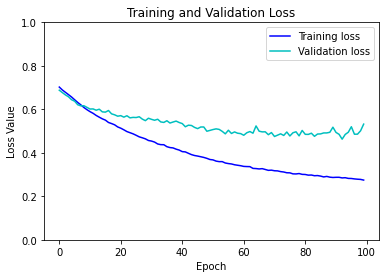

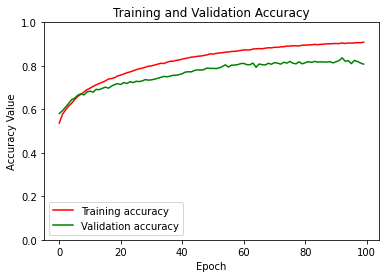

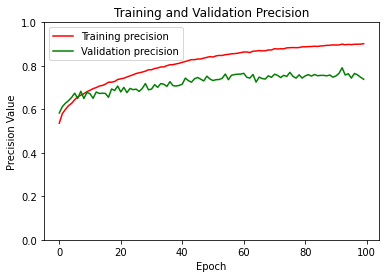

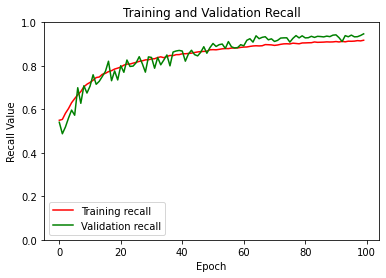

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'b', label='Training loss')
plt.plot(history.epoch, val_loss, 'c', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# ##########################################################

metrics = history.history['binary_accuracy']
val_metrics = history.history['val_binary_accuracy']

plt.figure()
plt.plot(history.epoch, metrics, 'r', label='Training accuracy')
plt.plot(history.epoch, val_metrics, 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# ##########################################################

metrics = history.history['precision']
val_metrics = history.history['val_precision']

plt.figure()
plt.plot(history.epoch, metrics, 'r', label='Training precision')
plt.plot(history.epoch, val_metrics, 'g', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# ##########################################################

metrics = history.history['recall']
val_metrics = history.history['val_recall']

plt.figure()
plt.plot(history.epoch, metrics, 'r', label='Training recall')
plt.plot(history.epoch, val_metrics, 'g', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


# Evaluate Model

## Human testing

In [ ]:
_, acc, prec, recall = model.evaluate(X_test_human_comb, y_test_human_comb, verbose=2)
print("**** Human ****\nAccuracy: {:.2f}%\nPrecision: {:.2f}%\nRecall: {:.2f}%".format(acc*100, prec*100, recall*100))

83/83 - 1s - loss: 0.7567 - binary_accuracy: 0.7146 - precision: 0.7326 - recall: 0.6757
**** Human ****
Accuracy: 71.46%
Precision: 73.26%
Recall: 67.57%


## Mouse testing

In [ ]:
_, acc, prec, recall = model.evaluate(X_test_mouse_comb, y_test_mouse_comb, verbose=2)
print("**** Mouse ****\nAccuracy: {:.2f}%\nPrecision: {:.2f}%\nRecall: {:.2f}%".format(acc*100, prec*100, recall*100))

83/83 - 1s - loss: 0.7407 - binary_accuracy: 0.7168 - precision: 0.7362 - recall: 0.6757
**** Mouse ****
Accuracy: 71.68%
Precision: 73.62%
Recall: 67.57%


# Reset Model

In [ ]:
'''Uncomment to reset tensorflow graphs'''
# tf.keras.backend.clear_session()

'Uncomment to reset tensorflow graphs'